## **📊 Flow**   
> step01 : Data   
> - 데이터 준비 및 분석   
> - 데이터 전처리

> setp02 : 모델 비교     
> - Binary Classification, Multi-class Classification 비교
> - 성능평가 : 정확도, 재현율, f1

> setp03 : 분석 실험   
> - Focal Loss, Class-balanced Loss 적용.   
> - Precision-Recall Trade-off   
> - XAI 기법   
> - 오분류 분석   

---
> ### step01 : Data   
> - 데이터 준비 및 분석   
> - 데이터 전처리

In [1]:
from utils import *

# 데이터 경로
data_path = '/home/dibaeck/sketch/study_Data4Quality/Assignment02_CovidClassifier/COVID19_1K'

---
>> 데이터 사이즈 다름 --> TASK : 데이터 리사이즈  

In [2]:
check_image_sizes(data_path)

Image: 1 - Size: (1507, 1052)
Image: 101 - Size: (1661, 1442)
Image: 1 - Size: (1088, 712)
Image: 101 - Size: (1304, 960)
Image: 201 - Size: (1328, 920)
Image: 301 - Size: (827, 448)
Image: 401 - Size: (1008, 704)
Image: 1 - Size: (1024, 1024)
Image: 1 - Size: (1765, 1503)
Image: 1 - Size: (1136, 680)
Image: 1 - Size: (3465, 3433)
Image: 1 - Size: (1461, 1140)
Image: 1 - Size: (1067, 768)
Image: 101 - Size: (1055, 642)
Image: 1 - Size: (550, 609)


---
>> 클래스 불균형 : COVID19 데이터가 적음.  --> TASK : Data Augmentation   

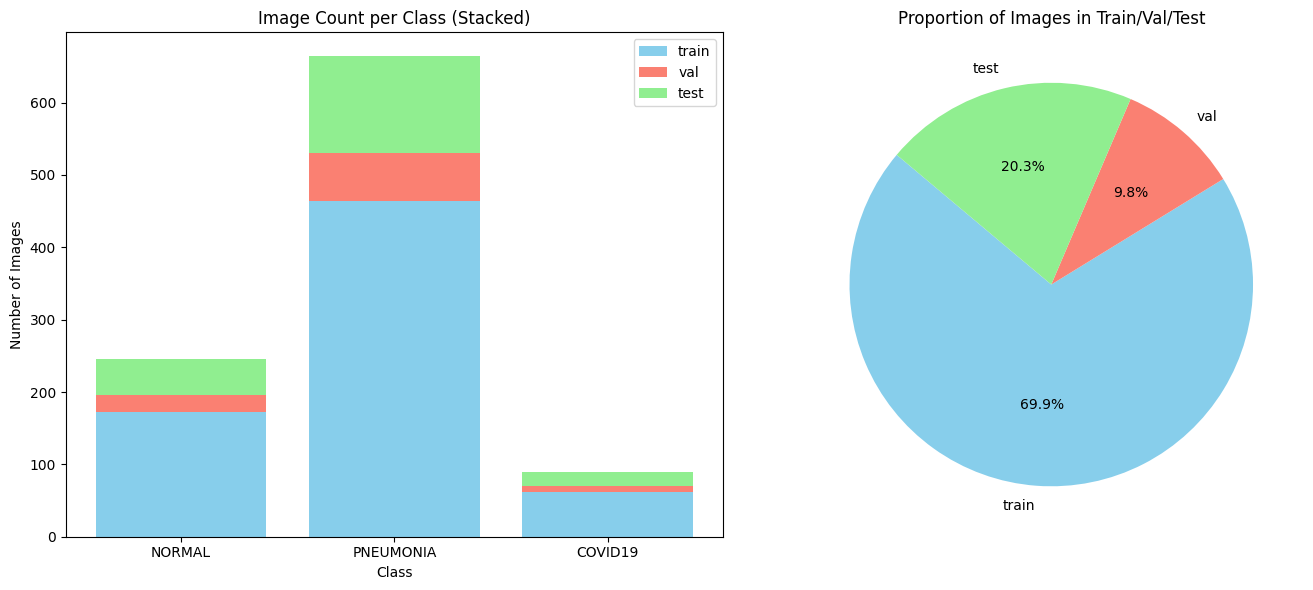

In [3]:
count_and_visualize_images(data_path)

클래스 불균형 해결 전략 : WeightedRandomSampler + FocalLoss

| 전략               | 설명                                                                 |
|--------------------|----------------------------------------------------------------------|
| **WeightedRandomSampler**          | 수 클래스를 더 자주 뽑히게 하는 샘플링 방식                |
| **Focal Loss**     | 소수 클래스의 어려운 샘플에 더 집중하는 loss function(의료 이미지에서 성능 개선에 효과적)                               |

---

In [4]:
######################################## setting 
from utils import *
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# 데이터 경로
data_path = '/home/dibaeck/sketch/study_Data4Quality/Assignment02_CovidClassifier/COVID19_1K'

# 데이터 정규화 및 리사이즈, 텐서화
transform = get_transform()

no1_target_classes = ['PNEUMONIA', 'NORMAL']
train_dataset1, val_dataset1, test_dataset1 = get_customdatasets(data_path, transform,no1_target_classes)
train_loader1,val_loader1,test_loader1 = get_dataloaders(train_dataset1,val_dataset1,test_dataset1,batch_size=4)

no2_target_classes = ['COVID19', 'NORMAL']
train_dataset2, val_dataset2, test_dataset2 = get_customdatasets(data_path, transform,no2_target_classes)
train_loader2,val_loader2,test_loader2 = get_dataloaders(train_dataset2,val_dataset2,test_dataset2,batch_size=4)

no3_target_classes = ['NORMAL',"PNEUMONIA",'COVID19']
train_dataset3, val_dataset3, test_dataset3 = get_customdatasets(data_path, transform,no3_target_classes)
train_loader3,val_loader3,test_loader3 = get_dataloaders(train_dataset2,val_dataset2,test_dataset2,batch_size=4)

In [6]:
from models_sketch import *
import torch.optim as optim

# 모델 불러오기
# Binary Classification (PNEUMONIA vs NORMAL)
binary_model_pneumonia_vs_normal = CustomDenseNet(num_classes=2)

# Binary Classification (COVID19 vs NORMAL)
binary_model_covid19_vs_normal = CustomDenseNet(num_classes=2)

# Multi-class Classification (COVID19 vs PNEUMONIA vs NORMAL)
multi_class_model = CustomDenseNet(num_classes=3)


# 지표 설정
# 각각의 모델에 대해 이진 분류에서는 Binary Cross Entropy를, 다중 클래스 분류에서는 Cross Entropy를 사용
# 이진 분류 모델 (PNEUMONIA vs NORMAL, COVID19 vs NORMAL) 
criterion_binary = nn.BCEWithLogitsLoss()  # 이진 분류에서 사용
optimizer_binary = optim.Adam(binary_model_pneumonia_vs_normal.parameters(), lr=0.001)

# 다중 클래스 분류 모델 (COVID19 vs PNEUMONIA vs NORMAL)
criterion_multi_class = nn.CrossEntropyLoss()  # 다중 클래스 분류에서 사용
optimizer_multi_class = optim.Adam(multi_class_model.parameters(), lr=0.001)

/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# 모델 학습
binary_model_pneumonia_vs_normal.model_train(train_loader1, criterion_binary, optimizer_binary)
binary_model_covid19_vs_normal.model_train(train_loader2, criterion_binary, optimizer_binary)
multi_class_model.model_train(train_loader3,criterion_multi_class,optimizer_multi_class)
# 뭐가 문제인데ㅜㅠㅜㅠㅜㅠㅜ

torch.Size([4, 3, 224, 224])


RuntimeError: GET was unable to find an engine to execute this computation

In [ ]:
# 모델 평가
binary_model_pneumonia_vs_normal.model_eval(test_loader)
binary_model_covid19_vs_normal.model_eval(test_loader)
multi_class_model.model_eval(test_loader)

# 모델 훈련 및 평가 실행
train_and_evaluate_models(train_loader, test_loader)

### 모델 성능 비교

| **모델**                          | **정확도 (Accuracy)** | **정밀도 (Precision)** | **재현율 (Recall)** | **F1-Score** | **Confusion Matrix**                                |
|-----------------------------------|----------------------|------------------------|---------------------|--------------|-----------------------------------------------------|
| **PNEUMONIA vs NORMAL**           | 0.9655               | 0.9286                 | 0.6842              | 0.7879       | [[183   1] <br> [  6  13]]                         |
| **COVID19 vs NORMAL**             | 0.9360               | 0.9744                 | 0.7600              | 0.8539       | [[152   1] <br> [ 12  38]]                         |
| **Multi-class (COVID19 vs PNEUMONIA vs NORMAL)** | 0.9064 | 0.9064 | 0.9064 | 0.9064 | [[ 12   1   6] <br> [  1  39  10] <br> [  1   0 133]] |

### 결론

- **PNEUMONIA vs NORMAL 모델**: 높은 정확도와 정밀도, 하지만 재현율이 상대적으로 낮음.
- **COVID19 vs NORMAL 모델**: 높은 정확도, 정밀도, 재현율을 보이며, 비교적 균형 잡힌 성능.
- **Multi-class 모델**: 세 가지 클래스에 대해 고른 성능을 보여주며, F1-Score와 정확도가 90% 이상으로 높은편.

---

> ## setp03 : 분석 실험   (Multi-class 기반)
> - Focal Loss, Class-balanced Loss 적용.   
> - Precision-Recall Trade-off   
> - XAI 기법   
> - 오분류 분석  

In [ ]:
# ① Focal Loss / Class-balanced Loss 적용
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # 클래스별 가중치 (list 또는 Tensor)

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss


In [ ]:
# ② Precision-Recall Trade-off 실험
from sklearn.metrics import precision_recall_curve

def plot_pr_curve(y_true, y_probs, class_idx, class_name):
    precision, recall, thresholds = precision_recall_curve(y_true == class_idx, y_probs[:, class_idx])
    plt.plot(recall, precision, label=f"{class_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR Curve: {class_name}")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# ③ XAI 기법: GradCAM, SHAP
# gradcam 예시 (torchcam)
from torchcam.methods import GradCAM
from torchvision.models import resnet18
cam_extractor = GradCAM(model, target_layer="layer4")

# 이미지 하나 통과시켜보기
out = model(img_tensor.unsqueeze(0))  # 예측
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)  # 클래스 기준 CAM

In [ ]:
# ④ 오분류 분석 및 보정 전략 제시
# 오분류된 이미지 저장
misclassified = []
for i, (img, true, pred) in enumerate(zip(images, labels, predictions)):
    if true != pred:
        misclassified.append((img, true, pred))
        # 저장 코드 작성 (예: save_image(img, f"wrong_{i}_true{true}_pred{pred}.png"))


In [ ]:
# 모델 학습 시 사용될 loss 함수 설정
criterion = FocalLoss(gamma=2, alpha=0.25, num_classes=3)  # 예시로 FocalLoss 사용

# 학습 과정에서 해당 loss를 사용하여 모델 훈련
